## Problem Statement

### Context


AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


###  Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing necessary libraries and data

In [3]:
# this will help in making the Python code more structured automatically (good coding practice)
# %load_ext nb_black

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [4]:
# loading the dataset
data = pd.read_csv("Credit+Card+Customer+Data.csv")

## Data Overview

- Observations
- Sanity checks

In [5]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


In [6]:
# get the sape of the data
data.shape

(660, 7)

In [7]:
# copying the data to another variable to avoid any changes to original data
mainDf = data.copy()

In [8]:
# checking datatypes and number of non-null values for each column
mainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [9]:
# statistical summary of the data
mainDf.describe(include="all").T### Summary of the dataset.

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


#### PReprocessing
- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

In [10]:
# checking for missing values
mainDf.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [11]:
# number of unique values in each column
data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

In [12]:
# fixing column names
mainDf.columns = [c.replace(" ", "_") for c in mainDf.columns]

In [13]:
# getting the count for each unique value in Customer_Key
data_grouped = mainDf.groupby("Customer_Key").count()

for i in data_grouped.loc[data_grouped.Sl_No >= 2].index:
    display(data.loc[mainDf.Customer_Key == i])

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


#### need to combine the data for each duplicated customer key

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

#### Univariate Analysis

In [14]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

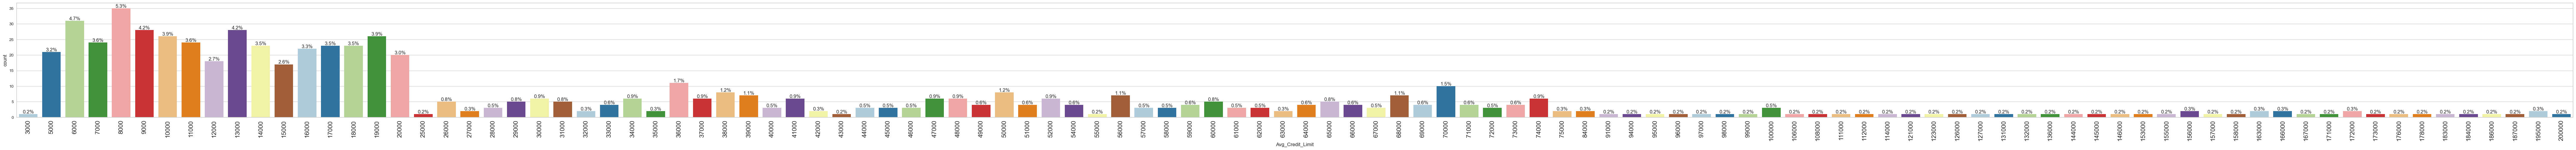

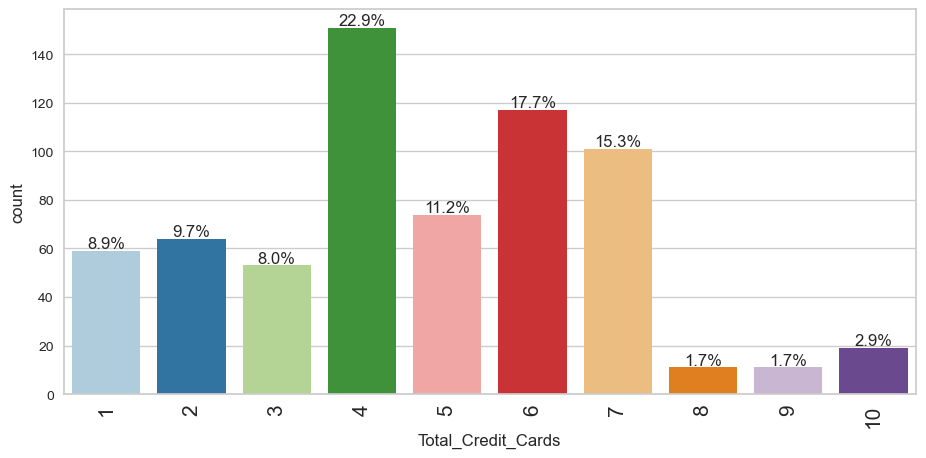

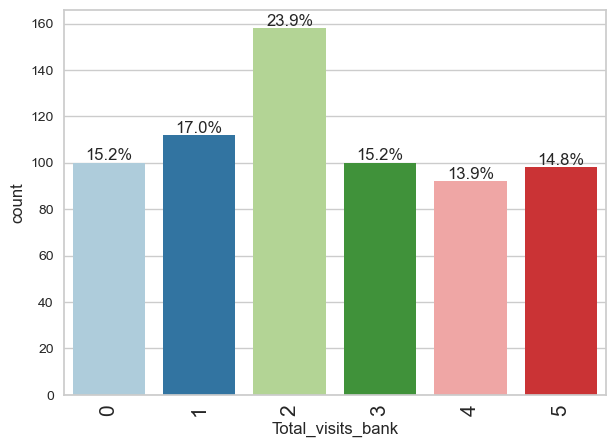

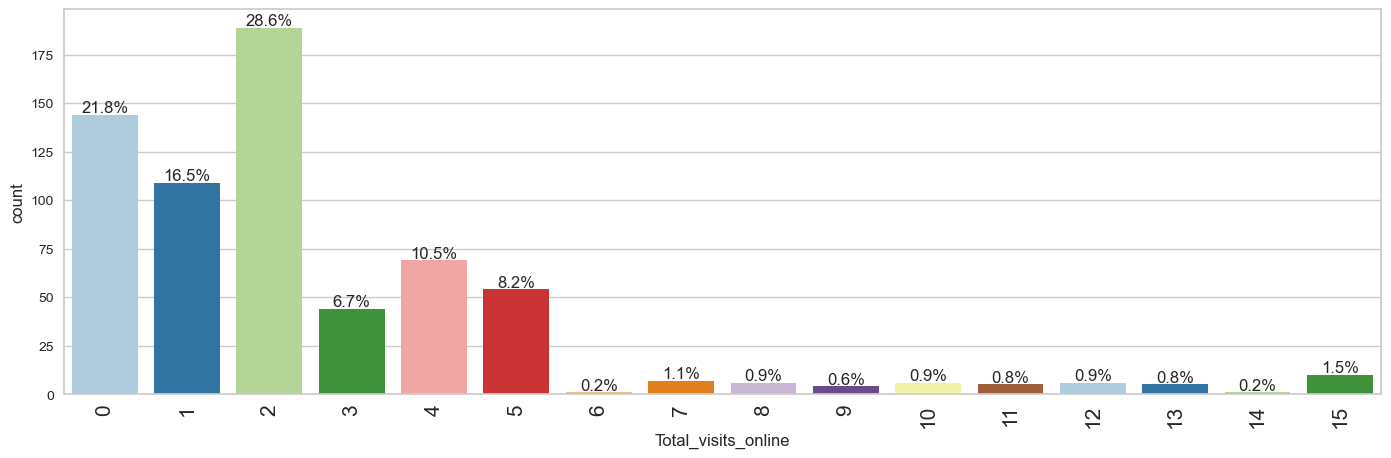

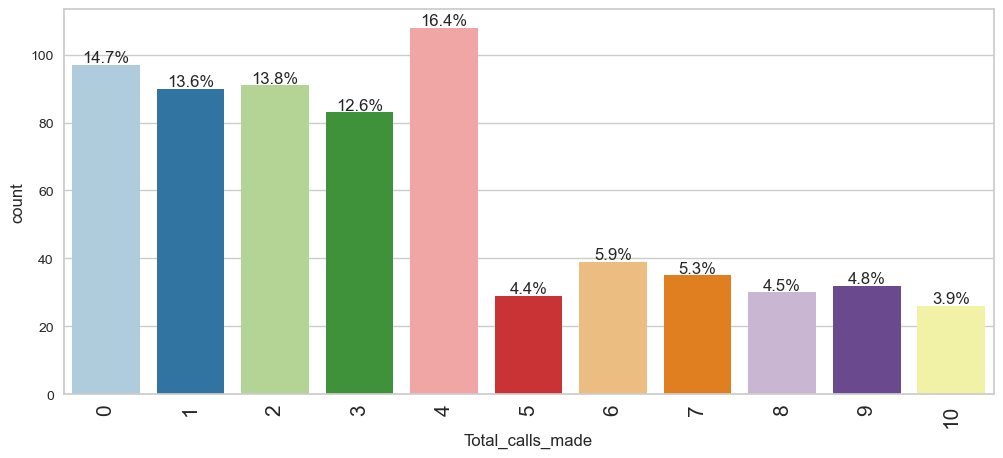

In [15]:
for col in mainDf.columns.tolist()[2:]:
    labeled_barplot(mainDf, col, perc=True)

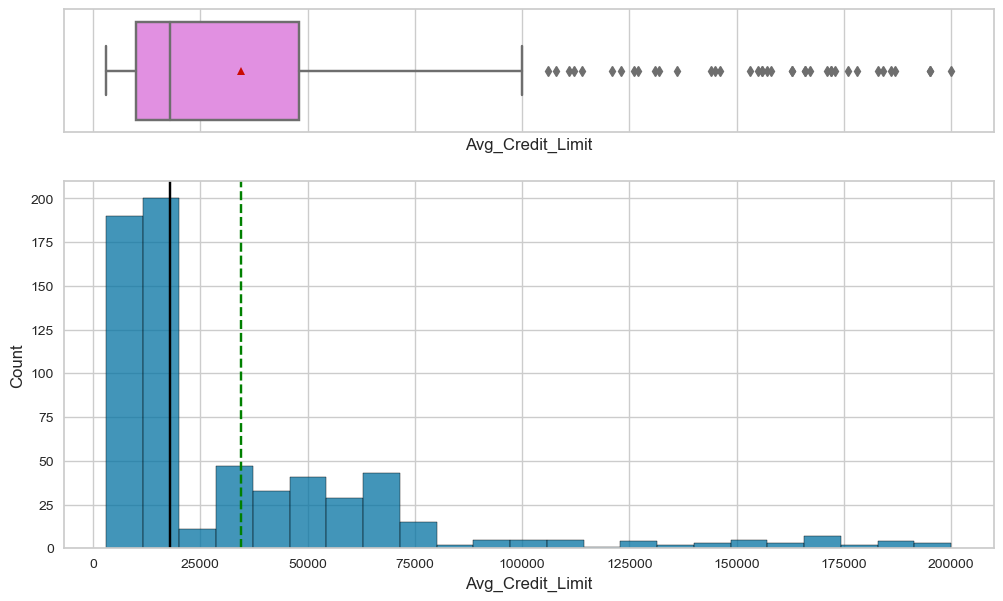

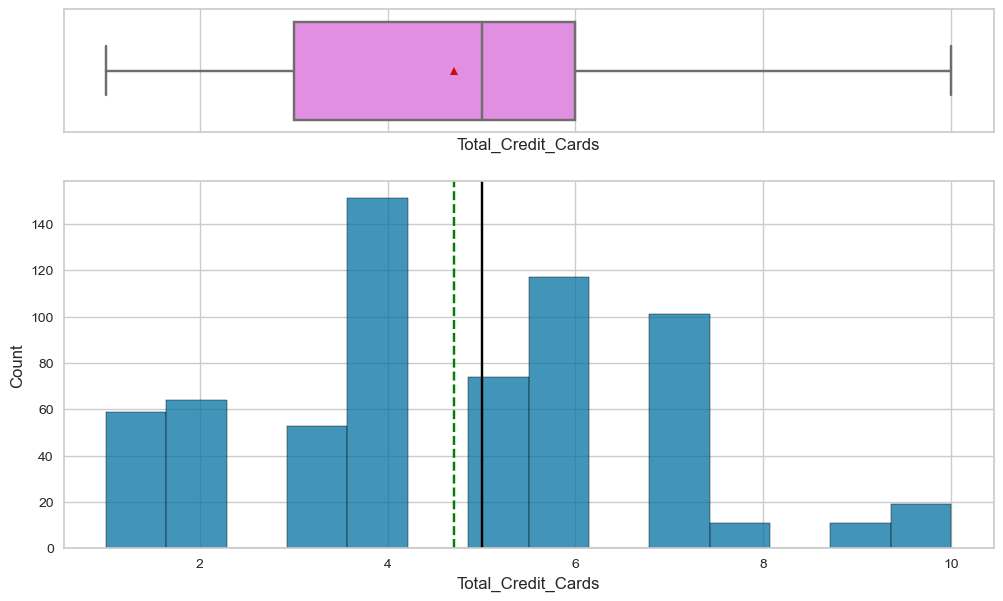

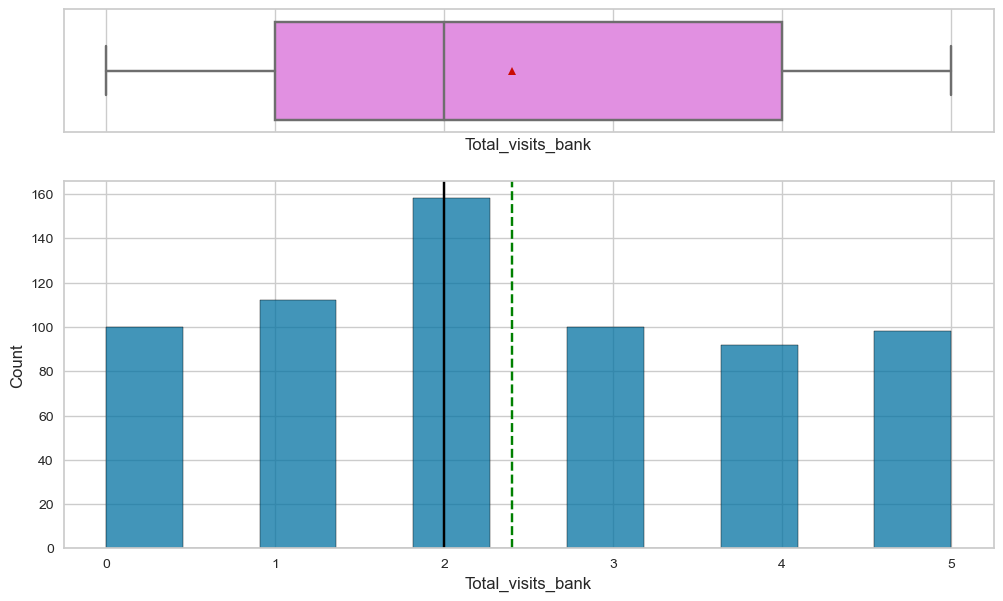

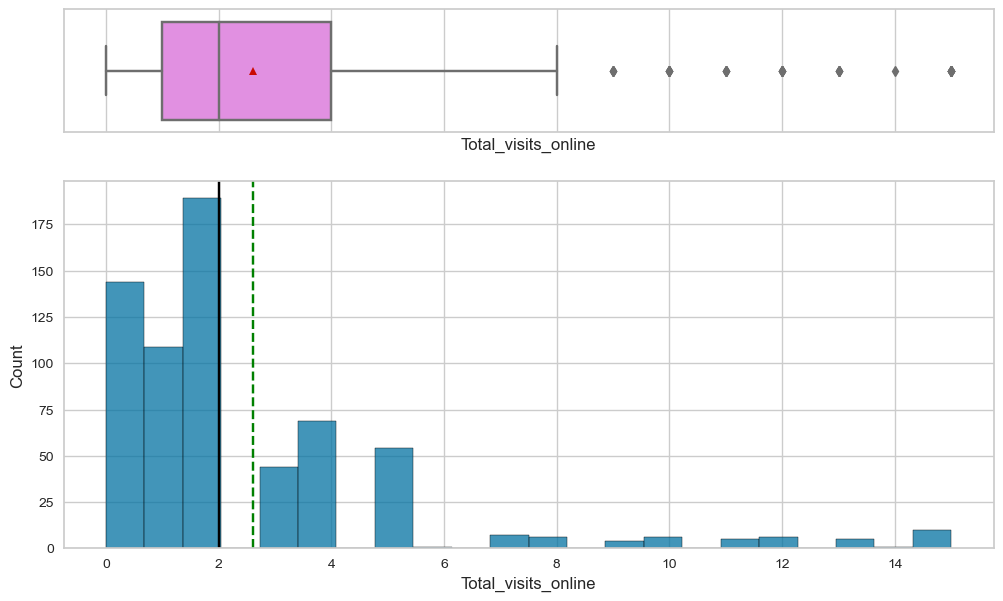

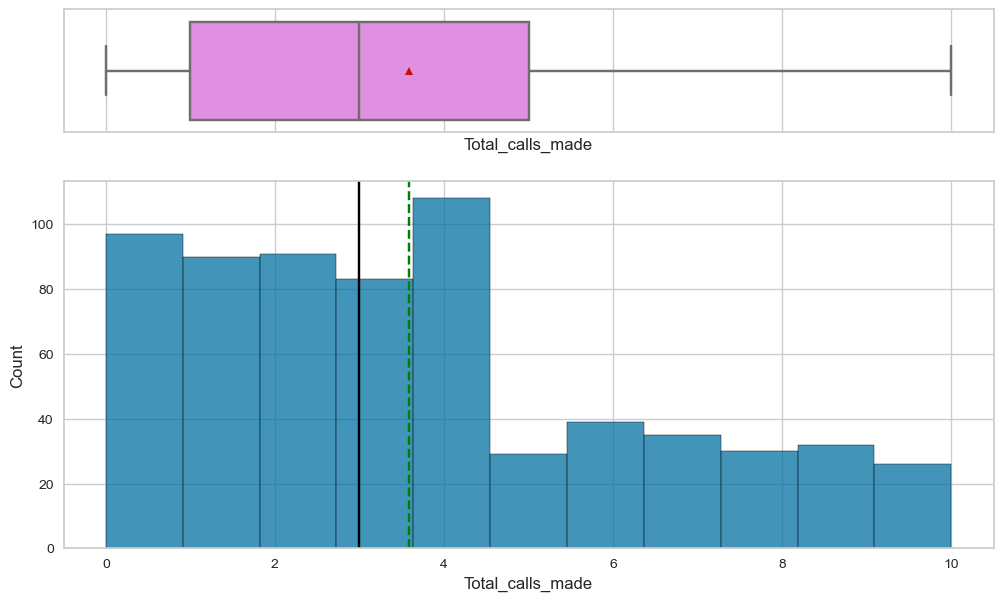

In [16]:
for col in mainDf.columns.tolist()[2:]:
    histogram_boxplot(data, col)

#### Observations
- 23% of the sample have 4 cards, this is the highest group
- 29% of the sample have visited 2 time online, the highest group.
- 22% have never logged in online
- 15% or 100 customers have never visited the bank at all.
- 24% of the sample have visited a bank in person 2 times, the highest group.
- 85% of the customers have called the bank at least 1 time.
- Average credit limit is about 30k in the dataset
- There are some cusotmers with a very high limit on credit which skews this data set to the right.
- Total visits int eh bank is most often 2, and between 0 tiems and 5.
- Total visits online is most often between 1 and 6 with a high amount of records betwqeen 1 and 3.
- Average amount of calls made is 3.5


#### Bivariate analysis


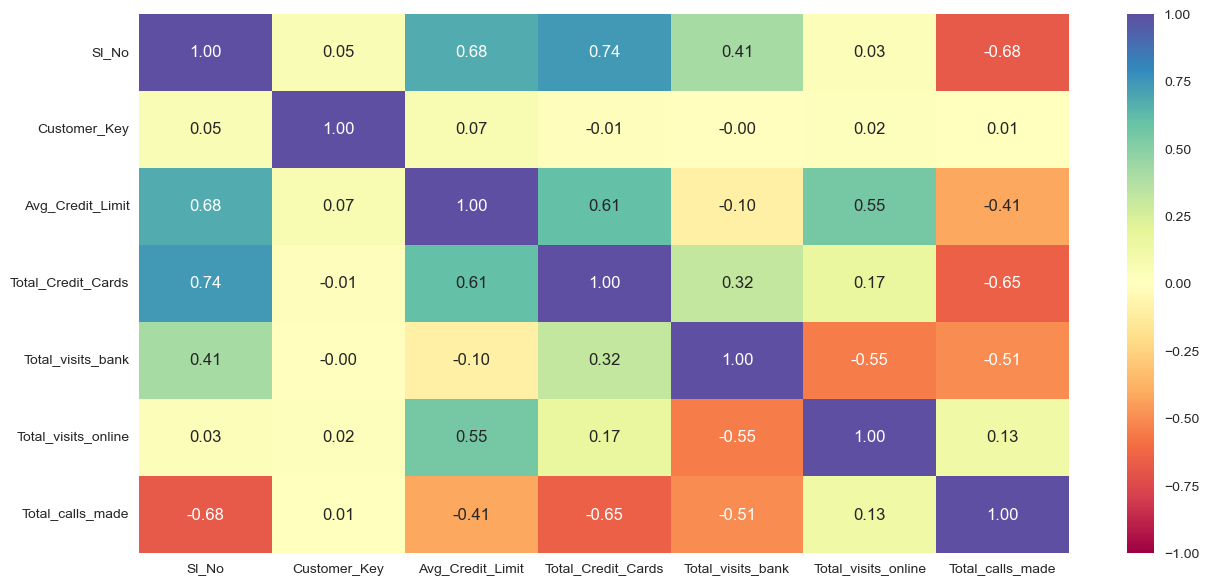

In [17]:
# selecting numerical columns
num_cols = mainDf.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 7))
sns.heatmap(
    mainDf[num_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

#### Observations
- Total credit cards and Average credit limit have a strong positive correlation
- Total credit cards and total visits online have a positive correlation
- Total credit cards and total calls made have a strong negative correlation, indicated less support needed with less credit cards.
- There is a negative correlation betewen total visits online and total visitis in the bank


### Questions

1. How is the distrubution of average credit limit of customer?
2. What percenatage of the customers have never made a service-related call to the bank?
3. What percentage of customers have never logged in to the online portal?
4. How many customers have never visited bank?
3. How are the different variables correlated with each other?

## K-means Clustering

In [31]:
# Sub setting the data
subset_df = mainDf.drop("Sl_No", axis=1)
subset_df = subset_df.drop("Customer_Key", axis=1)

In [32]:
subset_df.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [33]:
num_col = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank','Total_visits_online', 'Total_calls_made']

Number of Clusters: 1 	Average Distortion: 27070.75829859924
Number of Clusters: 2 	Average Distortion: 18449.779634256025
Number of Clusters: 3 	Average Distortion: 8517.918182146188
Number of Clusters: 4 	Average Distortion: 6392.576504125549
Number of Clusters: 5 	Average Distortion: 5394.745246897292
Number of Clusters: 6 	Average Distortion: 4152.273561110981
Number of Clusters: 7 	Average Distortion: 3392.3528887704206
Number of Clusters: 8 	Average Distortion: 3138.489792890401


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

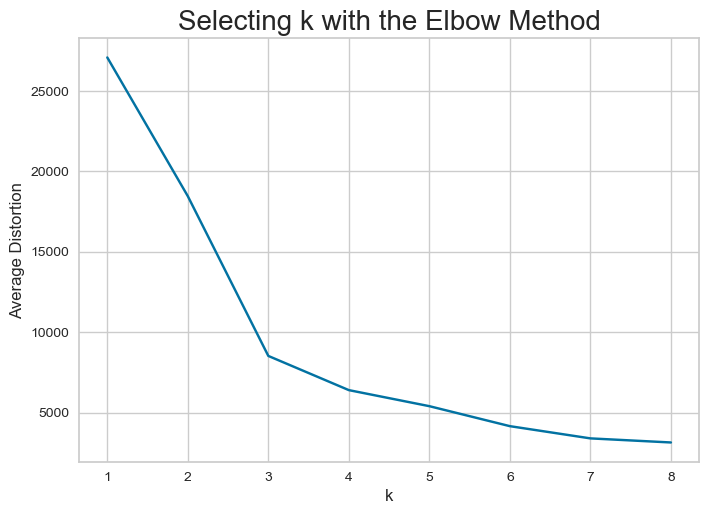

In [34]:
clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(subset_df)  # Fit kMeans on the data
    prediction = model.predict(subset_df)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(subset_df, model.cluster_centers_, "euclidean"), axis=1))
        / subset_df.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

### Observation
* In the above plot, the elbow is seen at K=3 indicating 3 cluster might be optimal.

For n_clusters = 2, silhouette score is 0.770112135258687
For n_clusters = 3, silhouette score is 0.7166257323382714
For n_clusters = 4, silhouette score is 0.6987312610796789
For n_clusters = 5, silhouette score is 0.7085077086163358
For n_clusters = 6, silhouette score is 0.5994220977307592
For n_clusters = 7, silhouette score is 0.6223014220132757
For n_clusters = 8, silhouette score is 0.6173604622491632
For n_clusters = 9, silhouette score is 0.6203174539817456


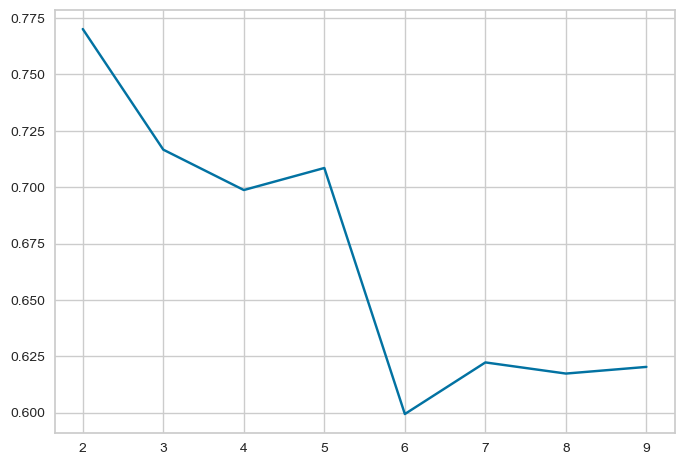

In [35]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((subset_df))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_df, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

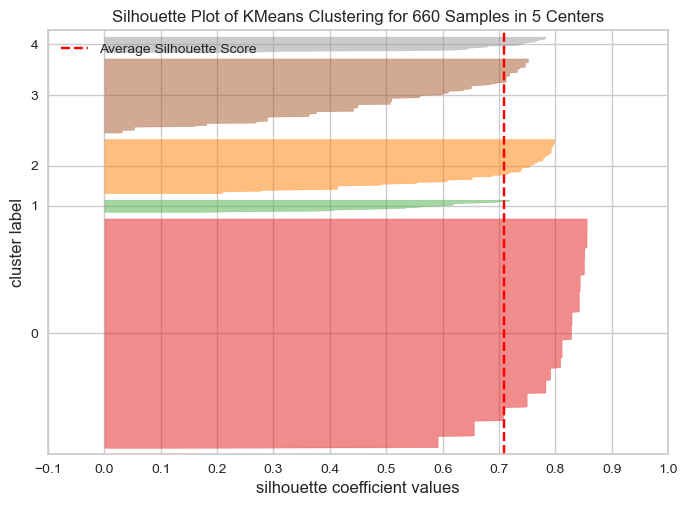

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [48]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

### Observation
- I started with 5 clusters, I have 5 different data points and silhouette scores drop a lot with 6 ore more clusters.
- With 5 cluters we have well defined clusters, decent separation, cluster label 0 is very large.

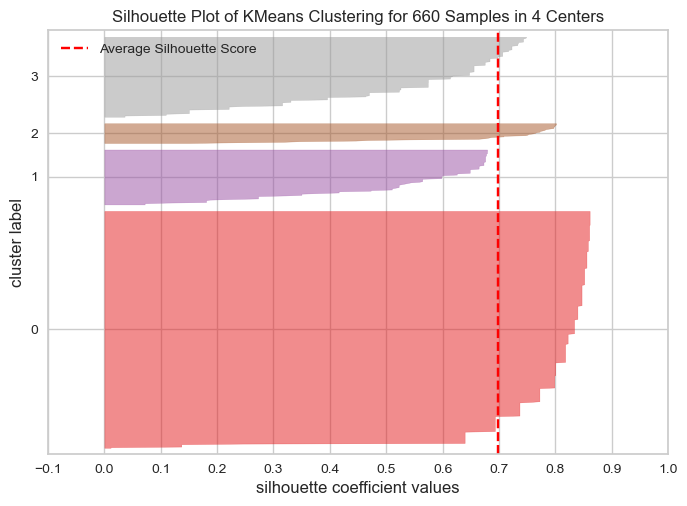

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [49]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

### Observation
- With 4 cluters we have well defined clusters, cluster 1 has all data points below the average so not a good one to use.

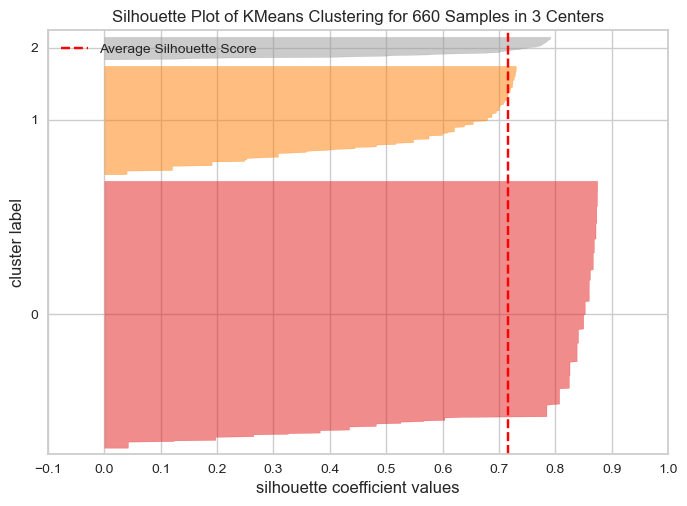

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [50]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

### Observation
- With 3 clusters we have well defined clusters.
- All hitting with data points getting to avverage score.


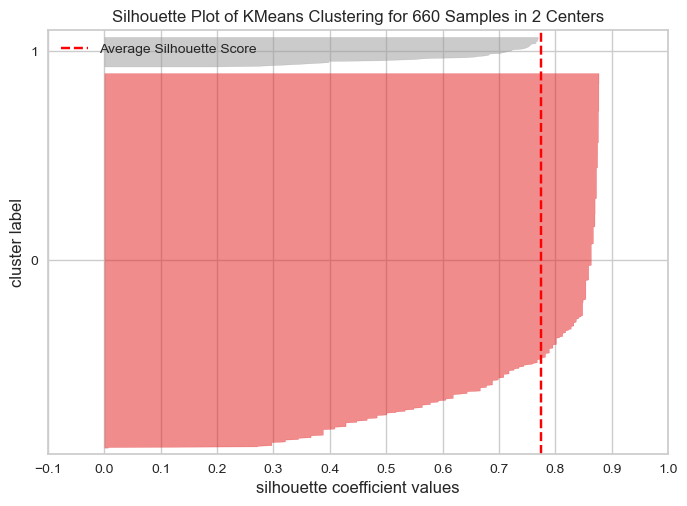

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [51]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

### Observation
- With 2 we have 1 really large cluster and 1 small.
- Not the best in this case.


### Applying KMeans clustering for k=3

In [53]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_df)

KMeans(n_clusters=3, random_state=0)

In [55]:
# adding kmeans cluster labels to the original dataframe
mainDf["K_means_segments"] = kmeans.labels_

### Cluster Profiling

In [58]:
cluster_profile = mainDf.groupby("K_means_segments").mean()

In [60]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,,,
0,237.601810,53892.902715,14400.452489,3.932127,2.242081,2.280543,4.436652
1,636.236842,56287.657895,155473.684211,8.763158,0.605263,10.947368,1.000000
2,494.072222,57965.327778,58588.888889,5.750000,3.177778,1.644444,2.033333


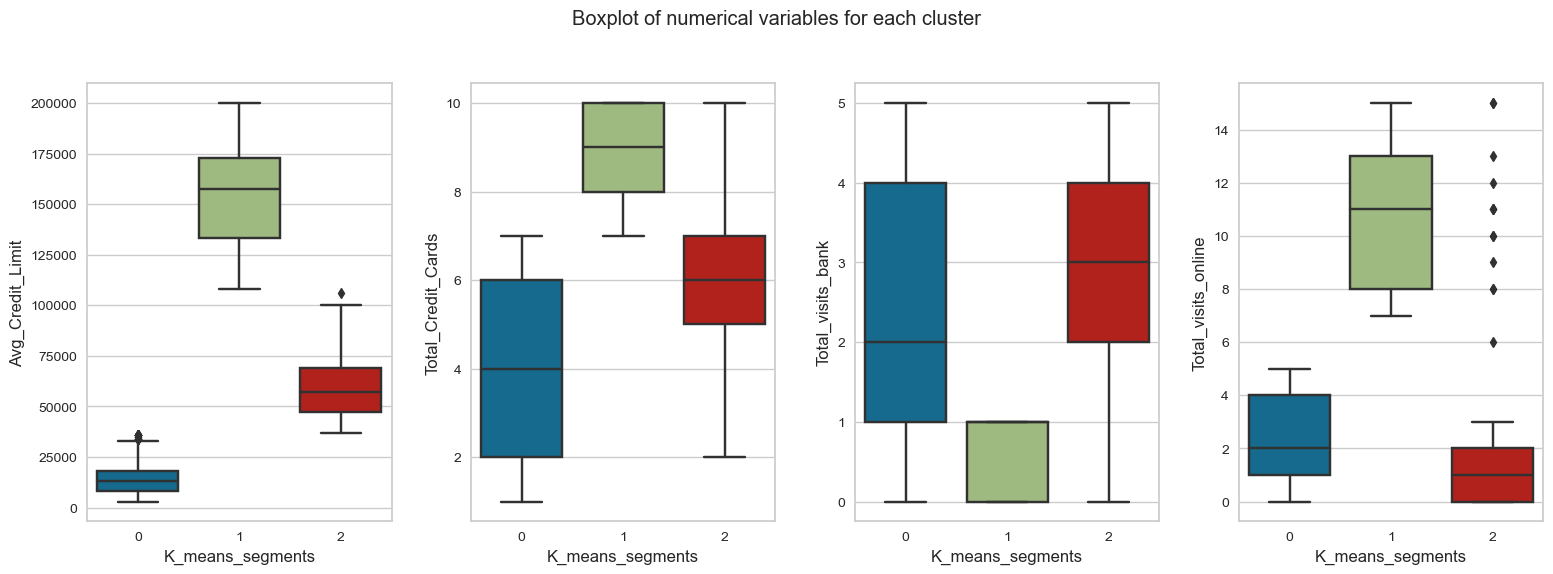

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii], y=mainDf[num_col[counter]], x=mainDf["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

#### Overview of clusters

- **Cluster 0**:
    - Credit limit lowest
    - on Average less credit card than other clusters. Min 1 and max 7
    

- **Cluster 1**:
    - Credit limit in the middle of other 2 clusters
    - on Average more credit card than other clusters. Minimum 7 and max 10
    

- **Cluster 2**:
    - Credit limit highest
    - on Average more credit card than other clusters. Minimum 2 and max 10
    - There are outliers on the higher end in this cluster for online visits


## Hierarchical Clustering

In [91]:
# Scaling the data 

sc = StandardScaler()
subset_scaled_df = pd.DataFrame(
    sc.fit_transform(mainDf.drop(["Customer_Key", "Sl_No"], axis=1)),
    columns=mainDf.drop(["Customer_Key", "Sl_No"], axis=1).columns,
)
subset_scaled_df.head()


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,1.576873,1.792110
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,1.576873,-0.303801
2,0.410293,1.058973,-0.860451,0.134290,0.145528,1.576873,0.394836
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,-0.680689,1.093473
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,1.576873,-1.701076


#### Cophenetic correlation

In [66]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.6249691363029527.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8419984932507404.
Cophenetic correlation for Euclidean distance and average linkage is 0.8951967463879936.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8675005219694865.
Cophenetic correlation for Chebyshev distance and single linkage is 0.6027915626359621.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8391233162841307.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8882140272153766.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8783996096577941.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.6218485928202105.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6219952398398024.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8434709049364356.
Cophenetic co

In [67]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8951967463879936, which is obtained with Euclidean distance and average linkage.


**Linkage methods with Euclidean distance only.**

In [68]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.6249691363029527.
Cophenetic correlation for complete linkage is 0.8419984932507404.
Cophenetic correlation for average linkage is 0.8951967463879936.
Cophenetic correlation for centroid linkage is 0.8945162487185994.
Cophenetic correlation for ward linkage is 0.7447526189825144.
Cophenetic correlation for weighted linkage is 0.8675005219694865.


In [69]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8951967463879936, which is obtained with average linkage.


#### Oberservations: We can conclude that average linkage is highest but centroid is also very high.

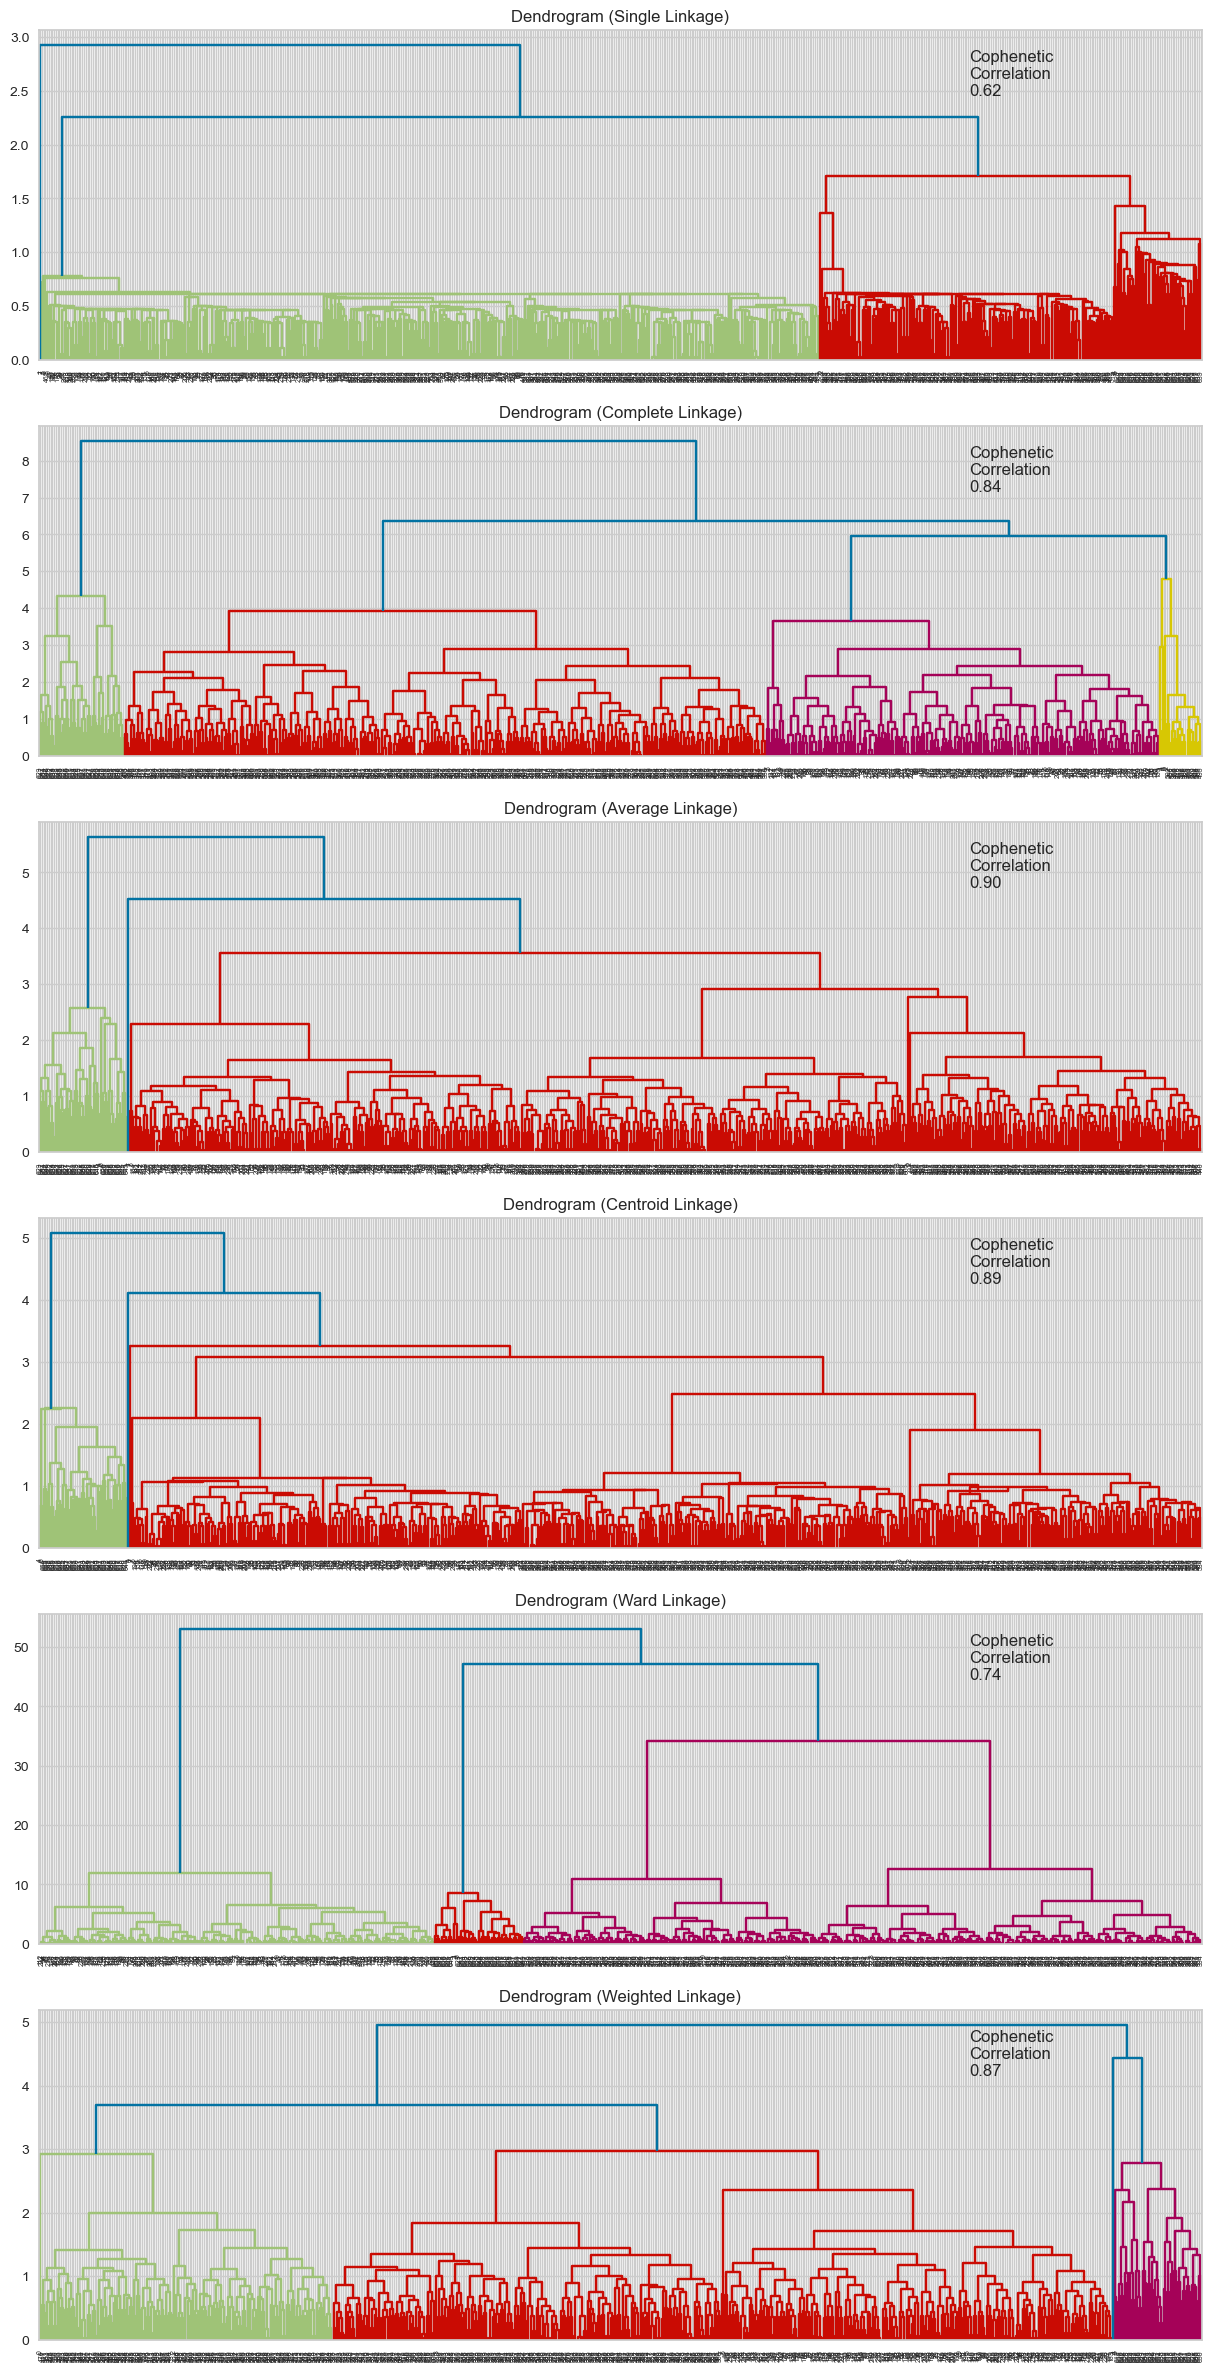

In [70]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

In [71]:
HCmodel = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=6)

In [73]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
mainDf["HC_Clusters"] = HCmodel.labels_

## Cluster Profiling and Comparison

In [83]:
cluster_profile = mainDf.groupby("HC_Clusters").mean()

In [112]:
cluster_profile["count_in_each_segment"] = (
    mainDf.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

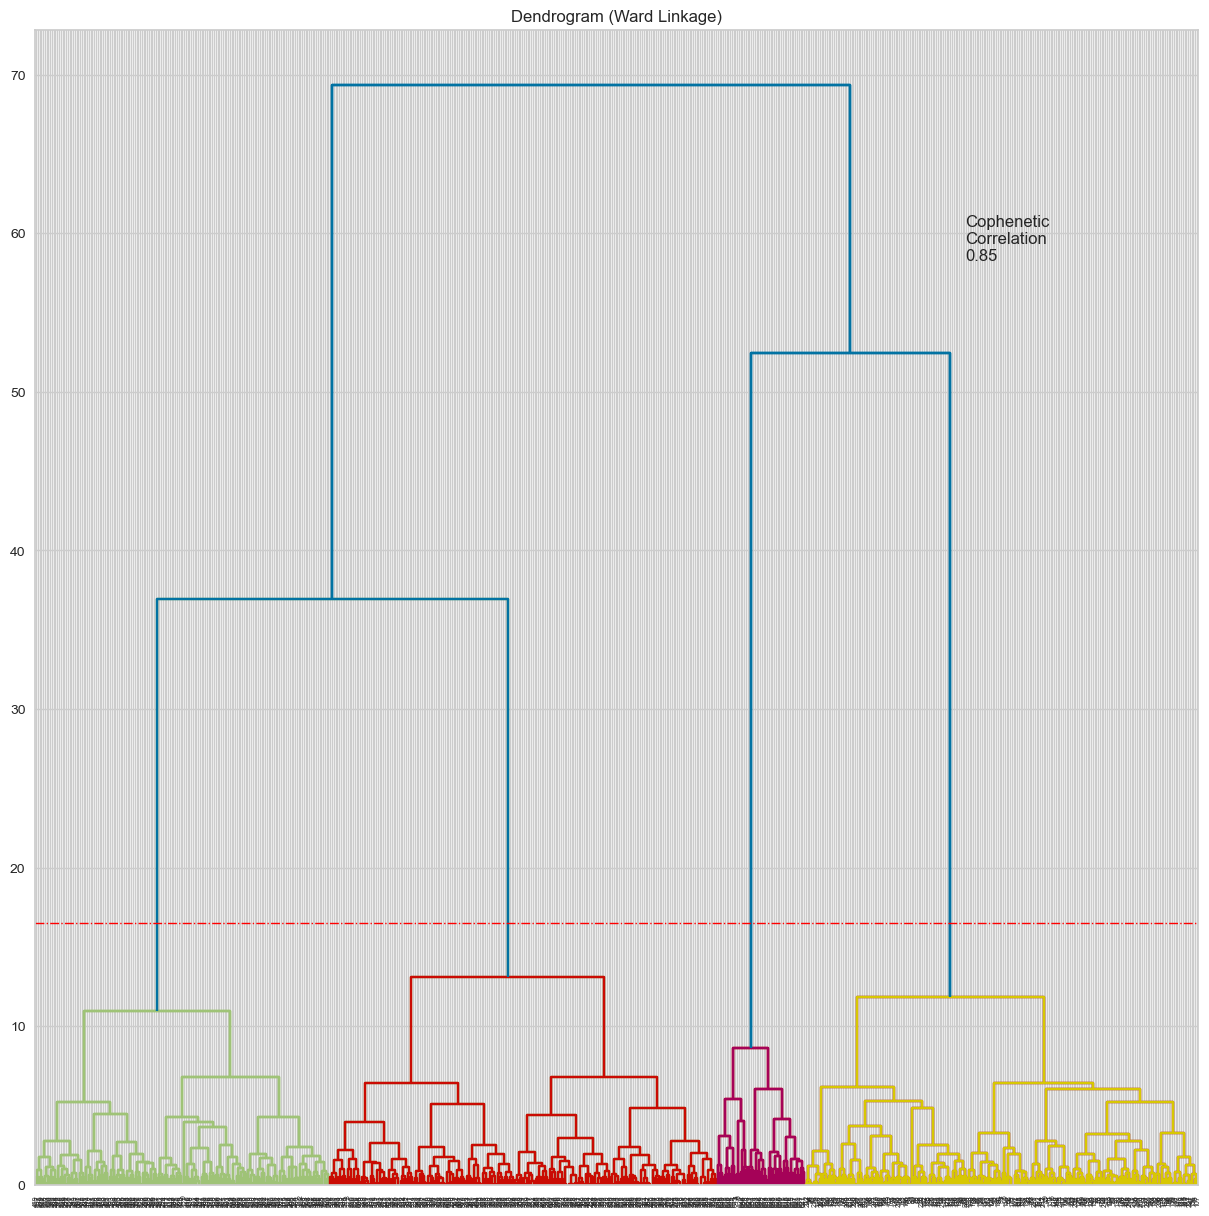

In [79]:
# list of linkage methods
linkage_methods = ["ward"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 15))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
dendrogram(Z, color_threshold=16.5)
plt.axhline(y=16.5, c="red", lw=1, linestyle="dashdot")

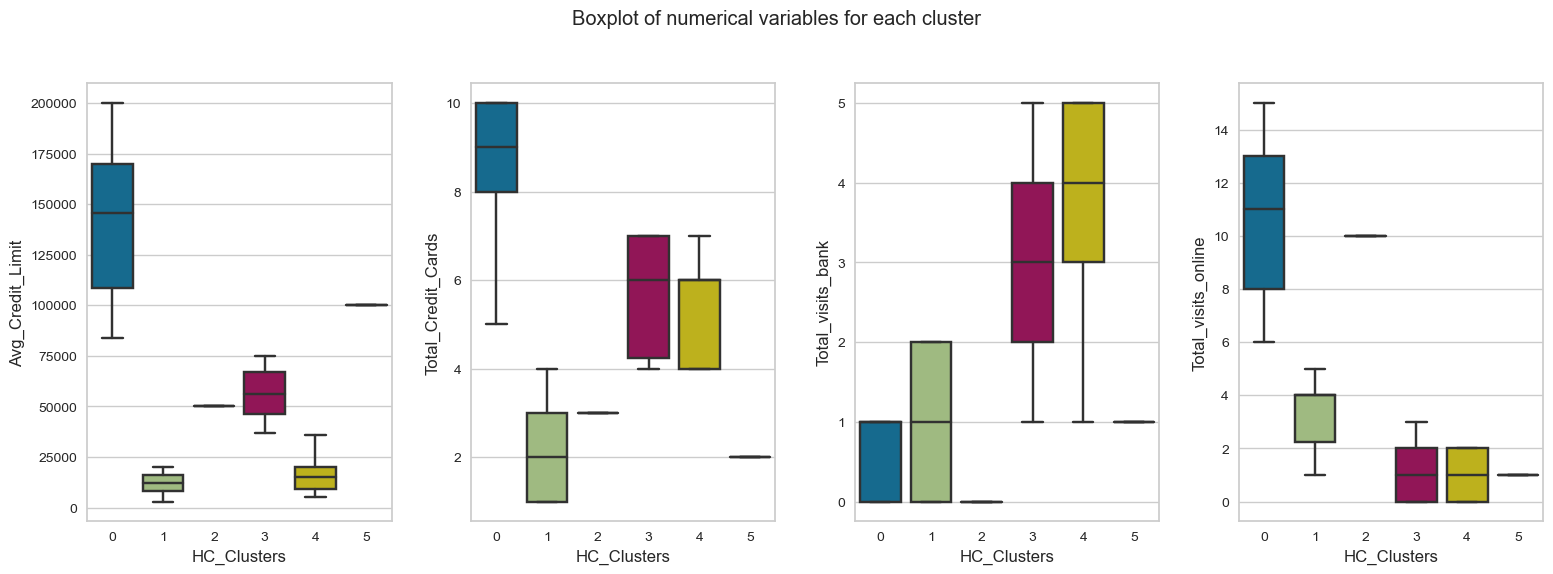

In [119]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii], y=mainDf[num_col[counter]], x=mainDf["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [115]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segment
HC_Clusters,,,,,,,,,
0,611.280000,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,1.240000,50
1,117.495495,55239.423423,12027.027027,2.400901,0.932432,3.531532,6.873874,0.000000,222
2,2.000000,38414.000000,50000.000000,3.000000,0.000000,10.000000,9.000000,2.000000,1
3,497.246988,57902.198795,55734.939759,5.578313,3.397590,0.939759,2.054217,2.000000,166
4,358.800000,52534.140909,16795.454545,5.477273,3.563636,1.018182,1.977273,0.000000,220
5,1.000000,87073.000000,100000.000000,2.000000,1.000000,1.000000,0.000000,2.000000,1


## K-means vs Hierarchical Clustering

You compare several things, like:
- Which clustering technique took less time for execution?
- Which clustering technique gave you more distinct clusters, or are they the same?
- How many observations are there in the similar clusters of both algorithms?
- How many clusters are obtained as the appropriate number of clusters from both algorithms?

You can also mention any differences or similarities you obtained in the cluster profiles from both the clustering techniques.

#### Observations
##### K Means 
- Outcome was 3 clusters

#### Hierarchical
- Outcome was 6 clusters


## Actionable Insights and Recommendations

- 


___